In [1]:
!pip uninstall nltk -y
!pip install nltk

In [1]:
# Run this cell and restart kernal if the next cell failes
from IPython.display import clear_output
clear_output(wait=True)
print("nltk Done")

nltk Done


In [2]:
import sys
print(sys.version)
print(spark.version)

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 1000)
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
df = spark.read.parquet('gs://msca-bdp-data-open/news_similar/')

#Only selecting the title and text column to focus on the required columns
df = df.select(['title', 'text'])
df = df.filter("text is not NULL and title is not NULL")
df.limit(5).toDF('title', 'text')

title,text
Local police on a...,Local police on a...
Biden Revokes Tr...,Biden Revokes Tru...
Woolworths superm...,Woolworths superm...
"Boy, 12, dies two...","Boy, 12, dies two..."
TikTok Planning t...,TikTok Planning t...


### I tested my code with 1000, 5000, 10000 samples for text and it's working but as soon as I pass the full dataset for text, the kernel fails and the cluster hangs, so limiting it to 10000 
### I tried with 7500, but it still fails so trying with 5000

#### Please check with Steve, I had completed using 10,000 samples but when I

In [5]:
df = df.limit(5000)

In [6]:
text = df.rdd.map(lambda x : x['text'])
title = df.rdd.map(lambda x : x['title'])

In [7]:
def get_tokens(df):
    return df\
        .map( lambda document: re.sub(r'[^a-zA-Z0-9 ]', '', document))\
        .map( lambda document: ' '.join(re.findall('[A-Z][^A-Z]*', document)))\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if len(x) >= 2] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

In [8]:
StopWords = stopwords.words("english")

text_tokens = get_tokens(text)
title_tokens = get_tokens(title)
clear_output()

In [9]:
def to_DF(rdd_, col):    
    row = Row(col)
    return rdd_.map(row).zipWithIndex().toDF([col, 'id'])

In [10]:
df_text = to_DF(text, 'text')
df_title = to_DF(title, 'title')

In [11]:
df_text.show(10)

+--------------------+---+
|                text| id|
+--------------------+---+
|{The Daily Ripple...|  0|
|{ TikTok looks to...|  1|
|{How a deepfake T...|  2|
|{Boy, 5, Who Drov...|  3|
|{Avril Lavigne De...|  4|
|{TikTok mum and b...|  5|
|{Teens using airs...|  6|
|{How a TikTok vid...|  7|
|{Mum-to-be goes v...|  8|
|{ Parachuting acc...|  9|
+--------------------+---+
only showing top 10 rows



In [12]:
df_title.show(10)

+--------------------+---+
|               title| id|
+--------------------+---+
|{The Daily Ripple...|  0|
|{TikTok looks to ...|  1|
|{How a deepfake T...|  2|
|{Boy, 5, Who Drov...|  3|
|{Avril Lavigne De...|  4|
|{TikTok mum and b...|  5|
|{Teens using airs...|  6|
|{How a TikTok vid...|  7|
|{Mum-to-be goes v...|  8|
|{Parachuting acci...|  9|
+--------------------+---+
only showing top 10 rows



In [13]:
def token_cleaning(tokens):
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    return df_tokens

In [14]:
df_text_tokens = token_cleaning(text_tokens)
df_title_tokens = token_cleaning(title_tokens)

In [15]:
##############################################################

In [16]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_text_tokens_vectorized = vectorize.fit(df_text_tokens).transform(df_text_tokens)
df_title_tokens_vectorized = vectorize.fit(df_title_tokens).transform(df_title_tokens)

In [17]:
display(df_text_tokens_vectorized.limit(5).toPandas())
display(df_title_tokens_vectorized.limit(5).toPandas())

22/11/18 04:17:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.3 MiB


,list_of_words,id,features
0,"[local, police, alert, wake, alleged, tik, tok, school, violence, campaign, reading, homenewsherecom, permission, edit, article, edit, close, welcome, guest, sign, log, dashboard, logout, account, account, dashboard, profile, saved, items, logout, home, us, contact, us, advertise, us, subscription, services, submission, forms, online, features, weather, local, events, daily, times, chronicle, news, national, legal, notices, obituaries, stoneham, news, legal, notices, obituaries, wilmington, news, legal, notices, obituaries, tewksbury, news, legal, notices, obituaries, sports, daily, times, chronicle, stoneham, independent, wilmington, town, crier, tewksbury, town, crier, bruins, celtics, patriots, red, sox, middlesex, east, features, movie, review, towns, calendar, legal, notices, subscribe, sign, log, dashboard, logout, account, ...]",0,"(8.0, 8.0, 9.0, 5.0, 2.0, 12.0, 0.0, 6.0, 3.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 8.0, 0.0, 0.0, 6.0, 2.0, 1.0, 1.0, 0.0, 5.0, 6.0, 0.0, 0.0, 4.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 6.0, 0.0, 0.0, 1.0, 0.0, 4.0, 1.0, 0.0, 1.0, 0.0, 0.0, 7.0, 1.0, 0.0, 5.0, 4.0, 0.0, 5.0, 0.0, 0.0, 6.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 4.0, 0.0, 2.0, 1.0, 6.0, 0.0, 0.0, 3.0, 0.0, 0.0, 5.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 2.0, 0.0, ...)"
1,"[biden, revokes, trumps, ban, chinese, apps, tik, tok, chat, orders, criteria, based, decision, indian, defence, news, home, india, indian, defence, news, army, air, force, navy, chief, defence, staff, aksai, chin, artificial, intelligence, anti, satellite, missile, article, 37035, coast, guard, armed, forces, surgical, strikes, armed, forces, welfare, aero, india, 2021, accidents, bilateral, relationship, ballistic, defense, biological, warfare, kashmir, sino, pak, borders, citizenship, amendment, act, civil, aviation, cyber, crime, cyber, warfare, corruption, corona, virus, pandemic, cross, border, firing, def, expo, news, defence, exports, defence, manufacturing, defence, acquisition, defence, partnership, defence, preparedness, defence, strategy, digital, india, doklam, standoff, drones, economy, energy, security, espionage, ...]",1,"(6.0, 6.0, 5.0, 1.0, 0.0, 2.0, 1.0, 2.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 2.0, 0.0, 4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...)"
2,"[woolworths, supermarket, worker, loses, mind, bizarre, wheel, discovery, new, viral, tik, tok, video, s7, monday, 14, march, 2022, click, open, navigation, news, sydney, sydney, melbourne, brisbane, queensland, perth, adelaide, hobart, darwin, show, local, sport, lifestyle, entertainment, tech, politics, finance, world, contact, us, discover, sunrise, morning, show, spotlight, podcasts, coupons, connect, follow, twitter, follow, facebook, follow, instagram, email, watch, local, sport, lifestyle, entertainment, tech, politics, finance, world, contact, us, lifestyle, woolworths, worker, loses, mind, bizarre, wheel, discovery, new, viral, tik, tok, video, woolies, team, member, liam, kirley, set, tongues, wagging, new, viral, video, amy, sinclair, lifestyle, hour, ago, updated, 140322, 242, ...]",2,"(8.0, 8.0, 2.0, 8.0, 29.0, 4.0, 6.0, 0.0, 0.0, 4.0, 7.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 3.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 4.0, 2.0, 1.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 1.

,list_of_words,id,features
0,"[local, police, alert, wake, alleged, tik, tok, school, violence, campaign, reading, homenewsherecom]",0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[biden, revokes, trumps, ban, chinese, apps, tik, tok, chat, orders, criteria, based, decision, indian, defence, news]",1,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)"
2,"[woolworths, supermarket, worker, loses, mind, bizarre, wheel, discovery, new, viral, tik, tok, video]",2,"(1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[boy, 12, dies, two, weeks, attempting, dangerous, blackout, challenge, tik, tok, scomau]",3,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[tik, tok, planning, move, commerce, business, 923]",4,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [18]:
#########################################################

In [19]:
mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5)
def get_df_hashed(df_vectorize):
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
    return model, df_hashed

In [20]:
model_text, df_hashed_text = get_df_hashed(df_text_tokens_vectorized)
model_title, df_hashed_title = get_df_hashed(df_title_tokens_vectorized)

In [21]:
df_hashed_text_joined = df_text.join(df_hashed_text, "id", how = 'left')
df_hashed_title_joined = df_title.join(df_hashed_title, "id", how = 'left')

In [22]:
print(df_hashed_text_joined.count())
print(df_hashed_title_joined.count())

5000


5000


In [23]:
df_hashed_title_joined.limit(5)

22/11/18 04:18:08 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 72.0 (TID 67) (hub-msca-bdp-dphub-students-jasmeetsingh-sw-l8r0.c.msca-bdp-students.internal executor 1): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3532/1570835170: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor

id,title,list_of_words,features,hashes
26,{TikTok may let c...,"[kanye, west, sla...","(9231,[0,1,126,15...","[[4.7945584E7], [..."
29,{Local school dis...,"[chanel, tik, tok...","(9231,[0,1,2,183,...","[[4.7945584E7], [..."
474,{Quick-thinking m...,"[panera, taps, vi...","(9231,[0,1,3,75,1...","[[4.7945584E7], [..."
964,{#ss501解散 Hashtag...,"[tik, tok, car, h...","(9231,[0,1,92,127...","[[4.7945584E7], [..."
1677,{How to make anim...,"[chilis, worker, ...","(9231,[0,1,3,18,2...","[[4.7945584E7], [..."


In [24]:
# print(df_hashed_title_joined.where(size(df_hashed_title_joined.list_of_words) <= 3).count())
# print(df_hashed_text_joined.where(size(df_hashed_text_joined.list_of_words) <= 80).count())

## Assumptions:
#### Since news articles and titles are usually very wordy,
#### So, if a title has less than 5 words (after removing special charecters and stop words), I'm ignoring those titles since it has very less number of words
#### And, if a text has less than 50 words (after removing special charecters and stop words), I'm ignoring those texts since it has very less number of words

### Various threshold tried
#### Title <= 5 words ==> 11% titles can be ignored
#### Title <= 4 words ==> 10% titles can be ignored
#### Title <= 3 words ==> 4% titles can be ignored
#### Text <= 80 words ==> 5% texts can be ignored
#### Text <= 100 words ==> 10% texts can be ignored

`print(df_hashed_title_joined.where(size(df_hashed_title_joined.list_of_words) <= 4).count())`

`print(df_hashed_text_joined.where(size(df_hashed_text_joined.list_of_words) <= 50).count())`

In [25]:
df_hashed_title_joined = df_hashed_title_joined.\
                                where(size(df_hashed_title_joined.list_of_words) >= 5)
df_hashed_text_joined = df_hashed_text_joined.\
                                where(size(df_hashed_text_joined.list_of_words) > 100)

In [26]:
def getJaccardBarChart(df, jaccard_distance):

    df_dups_text = model_text.approxSimilarityJoin(
                        df, df, jaccard_distance
                    ).filter("datasetA.id < datasetB.id").select(
                        col("distCol"),
                        col("datasetA.id").alias("id_A"),
                        col("datasetB.id").alias("id_B"),
                        col("datasetA.text").alias('text_A'),
                        col("datasetB.text").alias('text_B')
                    )

    df_dups_text.cache()
    df_dups_text.limit(5).toPandas()
    
    records = df.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups

    
    clear_output(wait=True)
    print ('Total records: ', records)
    print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
    print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)
    
    dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

    ax=dups_df.plot(figsize=(3, 4), kind = 'bar',y=['near_dups', 'unique'], fontsize=8, color=['C0', 'C1'], align='center', width=0.6, xlabel="Duplicates vs. Unique")
    ax.set_title('News title duplication analysis', fontsize=12)
    for p in ax.patches:
           ax.annotate(format(p.get_height(), '.1f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9),
                       textcoords = 'offset points') 
            
    return df_dups_text, records, dups

### Running Analysis on Text

In [27]:
text_dups_list = []

Total records:  4529
Duplicate titles based on { 0.2 } jaccard distance:  61
Unique titles based on { 0.2 } jaccard distance:  0.2 :  4468


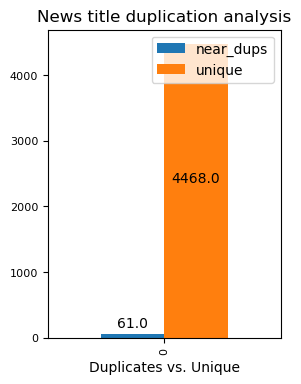

In [28]:
df_dups_text_20, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.2)
text_dups_list.append([records, dups, records - dups, 0.2])

Total records:  4529
Duplicate titles based on { 0.4 } jaccard distance:  306
Unique titles based on { 0.4 } jaccard distance:  0.4 :  4223


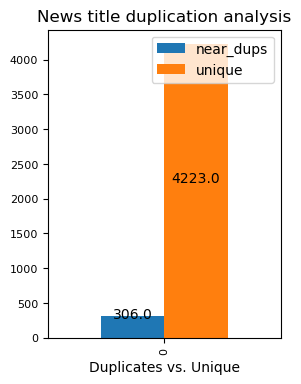

In [29]:
df_dups_text_40, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.4)
text_dups_list.append([records, dups, records - dups, 0.4])

Total records:  4554
Duplicate titles based on { 0.5 } jaccard distance:  478
Unique titles based on { 0.5 } jaccard distance:  0.5 :  4076


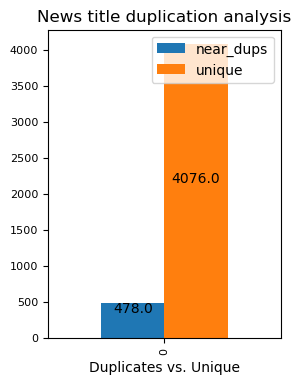

In [30]:
df_dups_text_50, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.5)
text_dups_list.append([records, dups, records - dups, 0.5])

Total records:  4554
Duplicate titles based on { 0.6 } jaccard distance:  802
Unique titles based on { 0.6 } jaccard distance:  0.6 :  3752


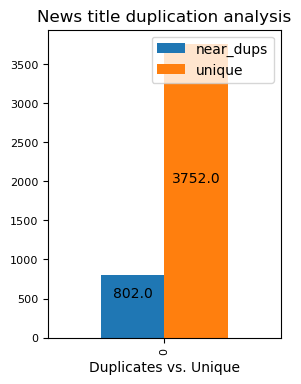

In [31]:
df_dups_text_60, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.6)
text_dups_list.append([records, dups, records - dups, 0.6])

Total records:  4529
Duplicate titles based on { 0.7 } jaccard distance:  1357
Unique titles based on { 0.7 } jaccard distance:  0.7 :  3172


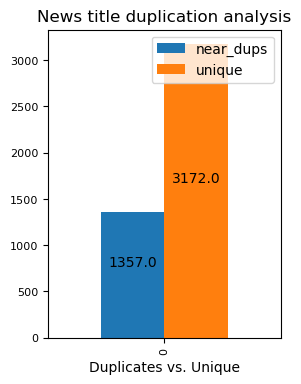

In [32]:
df_dups_text_70, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.7)
text_dups_list.append([records, dups, records - dups, 0.7])

### Running Analysis on Title

In [33]:
df_hashed_title_joined = df_hashed_title_joined.withColumnRenamed("title","text")
title_dups_list = []

Total records:  4596
Duplicate titles based on { 0.1 } jaccard distance:  421
Unique titles based on { 0.1 } jaccard distance:  0.1 :  4175


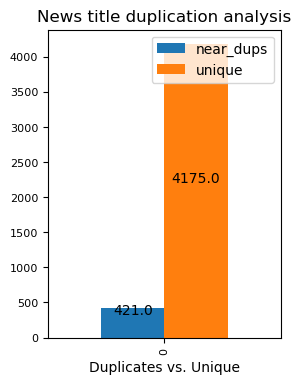

In [34]:
df_dups_title_10, records, dups = getJaccardBarChart(df_hashed_title_joined, 0.1)
title_dups_list.append([records, dups, records - dups, 0.1])

Total records:  4596
Duplicate titles based on { 0.2 } jaccard distance:  602
Unique titles based on { 0.2 } jaccard distance:  0.2 :  3994


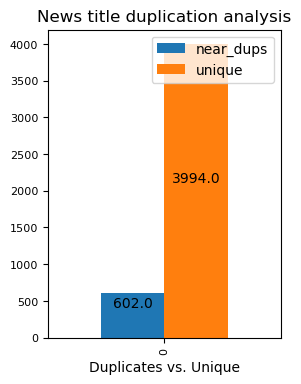

In [35]:
df_dups_title_20, records, dups = getJaccardBarChart(df_hashed_title_joined, 0.2)
title_dups_list.append([records, dups, records - dups, 0.2])

Total records:  4596
Duplicate titles based on { 0.4 } jaccard distance:  804
Unique titles based on { 0.4 } jaccard distance:  0.4 :  3792


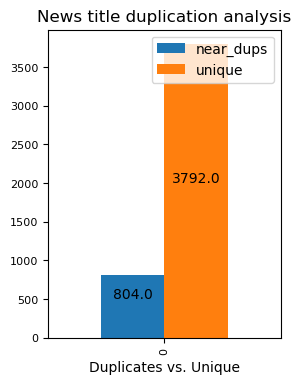

In [36]:
df_dups_title_40, records, dups = getJaccardBarChart(df_hashed_title_joined, 0.4)
title_dups_list.append([records, dups, records - dups, 0.4])

Total records:  4589
Duplicate titles based on { 0.6 } jaccard distance:  1097
Unique titles based on { 0.6 } jaccard distance:  0.6 :  3492


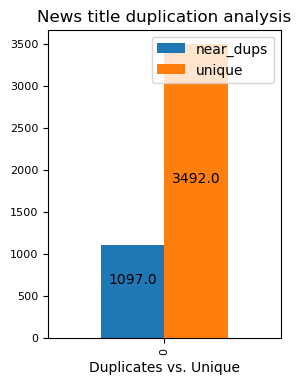

In [37]:
df_dups_title_60, records, dups = getJaccardBarChart(df_hashed_title_joined, 0.6)
title_dups_list.append([records, dups, records - dups, 0.6])

Total records:  4596
Duplicate titles based on { 0.8 } jaccard distance:  3808
Unique titles based on { 0.8 } jaccard distance:  0.8 :  788


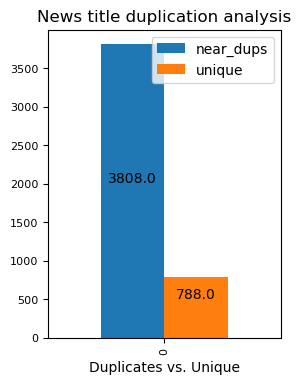

In [38]:
df_dups_title_80, records, dups = getJaccardBarChart(df_hashed_title_joined, 0.8)
title_dups_list.append([records, dups, records - dups, 0.8])

#### Choosing the thresholds of 0.4, 0.5, 0.7 for the text analysis and 0.2, 0.4 and 0.6 for title analysis

## Text and title analysis

In [39]:
def getCombinedDF(df1, df2, df3, threshold):
    
    df1_cols = df1.columns
    df2_cols = df2.columns
    df3_cols = df3.columns

    df1_id = df1.select(col(df1_cols[1]).alias('id_A_df1'), col(df1_cols[2]).alias('id_B_df1'))
    df2_id = df2.select(col(df2_cols[1]).alias('id_A_df2'), col(df2_cols[2]).alias('id_B_df2'))
    df3_id = df3.select(col('text_A'), col('text_B'),\
                        col(df3_cols[1]).alias('id_A_df3'), col(df3_cols[2]).alias('id_B_df3'))
    clear_output(wait=True)
    
    dups_combined = df3_id\
                        .join(df2_id, on=((df3_id.id_A_df3 == df2_id.id_A_df2) & (df3_id.id_B_df3 == df2_id.id_B_df2)), how="left_outer")\
                        .join(df1_id, on=((df3_id.id_A_df3 == df1_id.id_A_df1) & (df3_id.id_B_df3 == df1_id.id_B_df1)), how="left_outer")
    
    dups_combined.show(5)
    clear_output(wait=True)
    
    dups_combined = dups_combined.\
    withColumn(threshold[0], \
               when(col("id_A_df1").isNotNull(), "Duplicate").
               otherwise("Non-Dup")).\
    withColumn(threshold[1], \
               when(col("id_A_df2").isNotNull(), "Duplicate").
               otherwise("Non-Dup")).\
    withColumn(threshold[2], \
               when(col("id_A_df3").isNotNull(), "Duplicate").
               otherwise("Non-Dup")).\
    drop('id_A_df1', 'id_B_df1', 'id_A_df2', 'id_B_df2', 'id_A_df3', 'id_B_df3')
    dups_combined.show(5)
    clear_output(wait=True)
    
    return dups_combined

In [40]:
dups_combined= getCombinedDF(df_dups_text_40, df_dups_text_50, df_dups_text_70, ['threshold_40', 'threshold_50', 'threshold_70'])
dups_combined_sample = \
                dups_combined.filter(("threshold_40 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
                union\
                (dups_combined.filter(("threshold_40 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
                union\
                (dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
                orderBy('threshold_40', 'threshold_50', 'threshold_70')
clear_output(wait=True)
dups_combined_sample.toPandas().head(30)

22/11/18 04:36:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/18 04:36:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/18 04:36:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/18 04:36:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/18 04:36:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/18 04:36:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/18 04:36:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/18 04:36:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB


,text_A,text_B,threshold_40,threshold_50,threshold_70
0,"(Dystopia, 'she-cession,' TikTok dances: We're over you, 2021 Skip to main content Currently ReadingDystopia, 'she-cession,' TikTok dances: We're over you, 2021SubscribeSubscribee-editionSign In SubscribeCrosswordsPuzzles & ComicsPodcastsPuro PoliticsEN-DepthNewsLocalBorder & MexicoCoronavirusU.S. & WorldEducationWeatherBusinessSA Inc.SpaceX52 Weeks of Food TrucksOpinionFeatured ColumnistsSportsSpurs NationCowboys & NFLCollegesHigh SchoolLifestyleTravel & OutdoorsEntertainmentHome & GardenFoodCooking & RecipesNewsletterse-EditionPoliticsPrivacy NoticeTerms of Use MOST POPULAR Elon Musk warns SpaceX faces ‘genuine risk of bankruptcy’ Worst, best things about living in S.A., according to our readers FBI sniffed out Capitol riot suspect in Air Force basic training San Antonio airman is back on the job with an artificial foot BCSO identifies cadet who died during academy training Class in session for young Primo Pandemic’s strain on special ed grows acute at SAISD Woman admits...","(Dystopia, 'she-cession,' TikTok dances: We're over you, 2021 Skip to main content Currently ReadingDystopia, 'she-cession,' TikTok dances: We're over you, 2021SubscribeSubscribee-editionSign In HomeContact UsFAQCirculationNewslettersBreaking News signupPrint ArchivesGas PricesPrivacy NoticeTerms of UseNewsLocal NewsPolice and CourtsCoronavirusCommunity MattersModern HeroesBusinessStateU.S. and WorldSpecial SectionsSubmit NewsSportsHigh School SportsOpinionEditorialsLettersVoicesSubmit a LetterLifestylesHome and GardenLifestylesThrowbackEntertainmentReal EstateAnnouncementsAnnouncementsWeddingsEngagementsAnniversariesBirthdaysSubmit a WeddingSubmit an EngagementSubmit an AnniversarySubmit a BirthdaySubmit a BirthEventsFloodCoronavirusPhotosWeatherObitsSubmit an ObituaryClassifiedsContact UsSubmit a ClassifiedJobsSubscriber ServicesE-Edition Most Popular Sanford flood victim gets keys to new home Sanford couple loses everything in fire 'I won't say this was an easy decision...",Duplicate,Non-Dup,Duplicate
1,(Gordon Ramsay causes outrage on TikTok as he gleefully selects a lamb to slaughter | Daily Mail Online HomeU.K.NewsSportsU.S. ShowbizAustraliaFemailHealthScienceMoneyVideoTravelShopDailyMailTVHeadlines U.K. Showbiz Johnny Depp Amber Heard Meghan Markle TikTok Taylor Swift Kim Kardashian Video Games ...,(Will Instagram's catastrophic drive to copy TikTok's videos spell the end of Zuckerberg's reign? | Daily Mail Online HomeU.K.NewsSportsU.S. ShowbizAustraliaFemailHealthScienceMoneyVideoTravelShopDailyMailTVLatest Headlines Russia-Ukraine War Covid-19 Women's Rights Joe Biden Donald Trump Prince Harry World News Most read My ProfileLogout Login Privacy PolicyFeedbackFri...,Duplicate,Non-Dup,Duplicate
2,"( Govt issues notice to Tiktok, Helo; asks them to answer queries or face ban - BusinessToday Sign In Business Today Aaj Tak Dailyo Ichowk India Today Lallantop Sign In Home Economy Corporate Markets Money Industry Technology Opinion photos Videos Magazine Specials BT Specials Union Budget Special Reports BT Buzz Slowdown Blues Jobs Reality Check World Economic Forum Events Magazine Archives Business Today Money Today Gadgets and Gizmos News PTI feed Feedback Govt issues notice to Tiktok, Helo; asks them to answer queries or face ban Jul 18, 2019, Updated Jul 18, 2019, 6:32 PM IST (Eds: Updating with minor edits in intro, para 7) New Delhi, Jul 18 (PTI) The government has issued notices...","( Govt issues notice to TikTok, Helo; submit response by July 22 or face ban - BusinessToday Sign In Business Today Aaj Tak Dailyo Ichowk India Today Lallantop Sign In Home Economy Corporate Markets Money Industry Technology Opinion photos Videos Magazine Specials BT Specials Union Budget Special Reports BT Buzz Slowdown Blues Jobs Reality Check World Economic Forum Events Magazine Archives Business Today Money Today Gadgets and Gizmos News TECHNOLOGY News Feedback Govt issues notice to TikTok, Helo; submit re

### After going through the texts, the jaccard similarity of 0.5 seems appropriate, because if we look at the sentences 16, 17, 18 should be same but Threshold_40 classifies as Non-Dup but 21 & 22 should not be duplicate but threshold_70 gives as Duplicate => Thus 0.5 Threshold is good for text

In [41]:
dups_combined= getCombinedDF(df_dups_title_20, df_dups_title_40, df_dups_title_60, ['threshold_20', 'threshold_40', 'threshold_60'])
dups_combined_sample = \
                dups_combined.filter(("threshold_20 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
                union\
                (dups_combined.filter(("threshold_20 == 'Non-Dup' and threshold_40 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
                union\
                (dups_combined.filter(("threshold_40 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
                orderBy('threshold_20', 'threshold_40', 'threshold_60')
clear_output(wait=True)
dups_combined_sample.toPandas().head(30)

,text_A,text_B,threshold_20,threshold_40,threshold_60
0,"(How to See Who Viewed Your TikTok,)","(\r \tPag-udyok sa voter registration, idinaan sa Tiktok | ABS-CBN News\r ,)",Non-Dup,Non-Dup,Duplicate
1,"(Behind TikTok’s rise: Deeply engaged users, direct support for content creators | The Straits Times,)","(#cantbreathwithnoair Hashtag Videos on TikTok,)",Non-Dup,Non-Dup,Duplicate
2,"(Ready to vacation again? This TikTok travel guru has tips – KION546,)","(Anthropologie Primrose Mirror Dupes TikTok 2021: Cheap Alternatives | StyleCaster,)",Non-Dup,Non-Dup,Duplicate
3,"(Tennessee women uses Tiktok hand signal to tip off good Samaritan and escape kidnapping | Fox News,)","('Diva' Cat Steals the Spotlight from Opera Singer in Viral TikTok,)",Non-Dup,Non-Dup,Duplicate
4,"(Teens are using lemon juice and TikTok hacks to fake positive Covid tests to miss school | The Scotsman,)","(Pakistani court bans China’s TikTok over profanity claims – CBS17.com,)",Non-Dup,Non-Dup,Duplicate
5,"(TikTok going big on US e-commerce? Job listings offer clues,)","(#ohmygoshboystory Hashtag Videos on TikTok,)",Non-Dup,Non-Dup,Duplicate
6,"(Stevie Nicks Barred 'Dreams' From Nathan Apodaca's Viral TikTok NFT,)","(How to customize app icons with TikTok shortcut - Dexerto,)",Non-Dup,Non-Dup,Duplicate
7,"(Teen Mom Jenelle Evans chugs a beer & shows off curves in lace outfit in new TikTok as trolls say 'she let herself go’,)","(#ねね #ママとのやりとり #その2 #おならが出ちゃった #_のとき #我が家の日常 #みんなでtiktok #音量上げて,)",Non-Dup,Non-Dup,Duplicate
8,"(Girl, 10, strangles herself to death while ‘taking part in shocking TikTok challenge’,)","(This video is unavailable. Visit TikTok to discover more trending videos.,)",Non-Dup,Non-Dup,Duplicate
9,"(TikTok (ティックトック) で Naopaka🇯🇵 (@paka_1310) の動画を見る ,)","(#ริมุรุ Hashtag Videos on TikTok,)",Non-Dup,Non-Dup,Duplicate


### After going through the titles, the jaccard similarity of 0.4 seems appropriate, because if we look at the sentences 13, 19 should be same but Threshold_20 classifies as Non-Dup but 21 & 22 should not be duplicate but threshold_60 gives as Duplicate => Thus 0.4 Threshold is good for text

## Histogram of duplicates and uniques varying according to various thresholds

,counts,dups,unique,threshold
0,4596,421,4175,0.1
1,4596,602,3994,0.2
2,4596,804,3792,0.4
3,4589,1097,3492,0.6
4,4596,3808,788,0.8


<AxesSubplot:xlabel='threshold'>

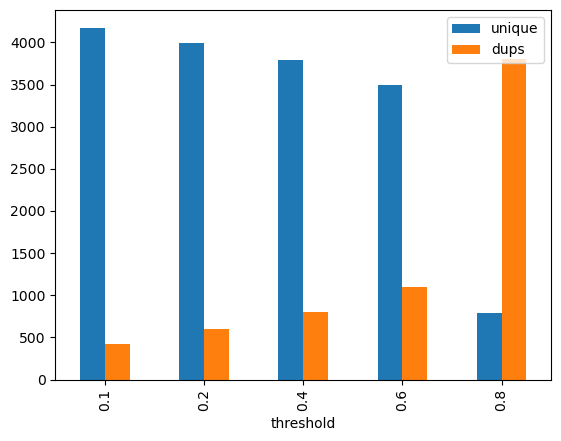

In [42]:
df = pd.DataFrame(title_dups_list, columns = ['counts', 'dups', 'unique', 'threshold'])
display(df.head())
df.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar')

,counts,dups,unique,threshold
0,4529,61,4468,0.2
1,4529,306,4223,0.4
2,4554,478,4076,0.5
3,4554,802,3752,0.6
4,4529,1357,3172,0.7


<AxesSubplot:xlabel='threshold'>

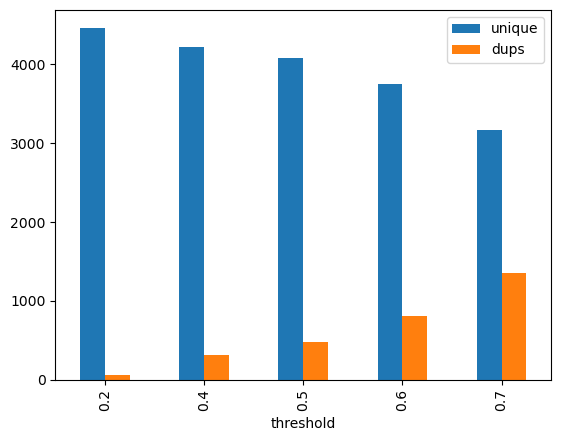

In [43]:
df = pd.DataFrame(text_dups_list, columns = ['counts', 'dups', 'unique', 'threshold'])
display(df.head())
df.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar')

# Conclusions

# 1. As the sample size increase, the percentage of duplicates goes up, i.e. if sample size is 1000 vs 10000, we see a higher ratio of dups in the 10000 sample
# 2. As we increase the jacard threshold, the number of dups goes up exponentially
# 3. Since the text has more words, the jacard threhold would have to be higher for text vs titles (0.5 vs 0.4)
# 4. Overall, texts would be better for confirming the similarity since we'll have more data and words to compare but we'll need more computing power to compare the texts, thus, if our focus on speed we can make do by checking uniqueness on the title, but if we have time - we'll use texts
# 5. To select the appropriate jaccard distance, we can print out the first 30 rows (if we're comparing 3 thresholds simultanenously) and compare what values suits our results. 